In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - triaxial_potential_DF.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Calculate the actions around the strange features in the triaxial DF
'''

__author__ = "James Lane"

In [2]:
## Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits

## galpy
from galpy import orbit
from galpy import potential
from galpy import df
from galpy.actionAngle import actionAngleAdiabatic
from galpy.actionAngle import actionAngleStaeckel
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.potential
import ast1501.util
import ast1501.fourier

In [3]:
# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta

## Future work

## Information
- Scipy re-gridding function

In [38]:
def plot_grid(hist, vmin, vmax, extent, cmap):

    # Plot the image. Rotate to account for histogram => plotting grid
    img = ax.imshow(np.rot90(hist), interpolation='nearest',
                    extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add the image masks. Assumes same geometry as hist.
#     if plot_low_N_mask == True:
#         img_mask = ax.imshow(np.rot90(low_N_mask), interpolation='nearest',
#                              extent=extent)
#     img_mask = ax.imshow(np.rot90(no_N_mask), interpolation='nearest',
#                          extent=extent)

    # Colorbar
    cbar = plt.colorbar(img)
    
    # Add the sun and it's orbit
    ax.scatter(x_sun, 0, marker=r'$\odot$', color='Black', s=256)
    orbit_circle = plt.Circle((0, 0), x_sun, edgecolor='Black', facecolor='None')
    ax.add_artist(orbit_circle)
    
    # Decorate
    ax.set_xlabel(r'X$_{GC}$ [kpc]')
    ax.set_ylabel(r'Y$_{GC}$ [kpc]')
    ax.set_xlim(x_lo, x_hi)
    ax.set_ylim(y_lo, y_hi)
    ax.tick_params(direction='in', top='on', right='on')
    
    return fig, ax, cbar
#def

# Load simulated Data

In [4]:
sim_halo_data_b12 = np.load('data/data_R7.5-14.5_b12.npy')
print('\nRadii for b=1.2')
for i in range( sim_halo_data_b12.shape[0] ):
    print( str(sim_halo_data_b12[i][0])+' kpc' )
###i

sim_halo_data_b09 = np.load('data/data_R7.5-14.5_b09.npy')
print('\nRadii for b=0.9')
for i in range( sim_halo_data_b09.shape[0] ):
    print( str(sim_halo_data_b09[i][0])+' kpc' )
###i


Radii for b=1.2
7.5 kpc
8.5 kpc
9.5 kpc
10.5 kpc
11.5 kpc
12.5 kpc
13.5 kpc
14.5 kpc

Radii for b=0.9
7.5 kpc
8.5 kpc
9.5 kpc
10.5 kpc
11.5 kpc
12.5 kpc
13.5 kpc
14.5 kpc


In [5]:
len(sim_halo_data_b12)

8

# Define the re-gridding function

In [42]:
def regrid_polar_rect(data_r, data_phi, data_vals, grid_x, grid_y, method='cubic'):
    
    # First we must translate the polar coordinates into data coordinates
    data_x = -np.cos( data_phi ) * data_r
    data_y = np.sin( data_phi ) * data_r
    
    # Now construct the array to feed to griddata
    data_posns = np.array([ data_x, data_y ]).T
    
    # Now make the new grid
    grid_data = griddata( data_posns, data_vals, (grid_x, grid_y), method=method )
    
    return grid_data

# Attempt to re-grid b12

In [43]:
# Construct the linear data position arrays by looping over the input data

r_data = np.array([])
phi_data = np.array([])
vr_data = np.array([])
vt_data = np.array([])

for i in range( len(sim_halo_data_b12) ):
    
    # Get the azimuth and radius data arrays
    phi_data_append = sim_halo_data_b12[i][1]
    r_data_append = np.ones_like( phi_data_append ) * sim_halo_data_b12[i][0]
    vr_data_append = sim_halo_data_b12[i][2]
    vt_data_append = sim_halo_data_b12[i][3]
    
    # Now append to the data 
    phi_data = np.append( phi_data, phi_data_append )
    r_data = np.append( r_data, r_data_append )
    vr_data = np.append( vr_data, vr_data_append )
    vt_data = np.append( vt_data, vt_data_append )
    
###i

## Decide rectangular gridding parameters

In [60]:
# Bins per dimension
n_xbins = 20j
n_ybins = 40j

# Ranges
x_hi = -5
x_lo = -15
y_hi = 10
y_lo = -10
bin_range = [ [x_lo,x_hi], [y_lo,y_hi] ]

# Deltas
dx = (x_hi-x_lo)/n_xbins
dy = (y_hi-y_lo)/n_ybins

grid_x, grid_y = np.mgrid[ x_lo:x_hi:n_xbins, y_lo:y_hi:n_ybins ]

In [61]:
grid_vr = regrid_polar_rect( r_data, phi_data, vr_data, grid_x, grid_y )

In [62]:
x_sun = -8.125

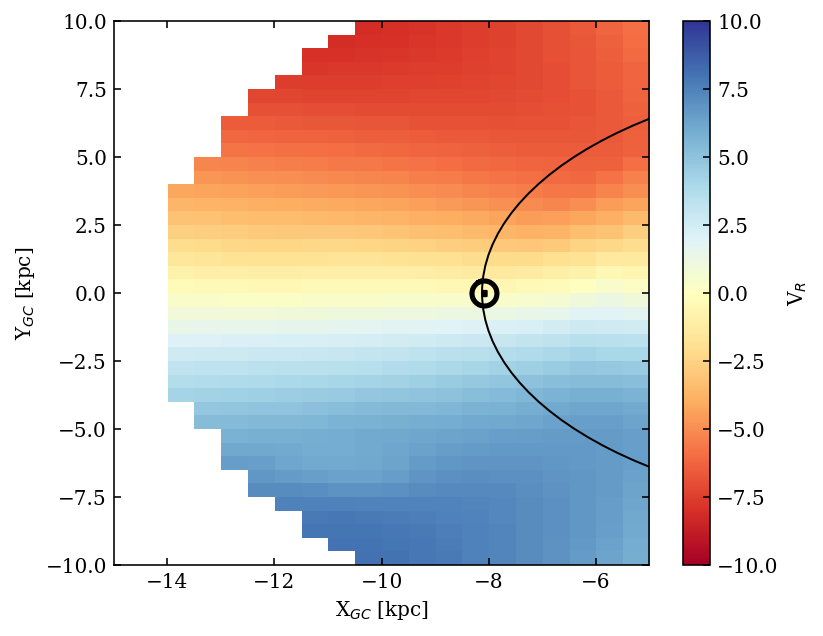

In [63]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = plot_grid(grid_vr, -10, 10, [x_lo,x_hi,y_lo,y_hi], 'RdYlBu')

cbar.set_label(r'V$_{R}$')
ax.set_aspect('auto')

plt.show()
fig.savefig('VR_gridded_B12.pdf')
plt.close('all')